# Minimum example for end-to-end learning with pypsps (with Kang-Schafer)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pypsps
import pypsps.datasets
import pypsps.keras.models
import pypsps.inference
import pypsps.keras.callbacks

# Simulating data

In [4]:
ks_sampler = pypsps.datasets.KangSchafer(true_ate=20, seed=123)
ks_data = ks_sampler.sample(n_samples=1000)
ks_data.to_data_frame().head()

,outcome,treatment,z1,z2,z3,z4,x1,x2,x3,x4
0,195.861788,1,-1.085631,0.997345,0.282978,-1.506295,0.581110,10.745574,0.202998,379.901059
1,195.488662,1,-0.578600,1.651437,-2.426679,-0.428913,0.748787,11.058150,0.282511,450.395521
2,222.810098,0,1.265936,-0.866740,-0.678886,-0.094709,1.883192,9.809357,0.180959,362.466410
3,229.073054,0,1.491390,-0.638902,-0.443982,-0.434351,2.107906,9.882625,0.188639,358.221742
4,318.044041,0,2.205930,2.186786,1.004054,0.386186,3.013087,10.216971,0.326506,509.539087


In [5]:
# Naive ATE
ks_data.naive_ate()

0.5877855068033

# Building a PSPS model for binary treatment and continuous outcome

In [6]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(
    n_states=4, n_features=ks_data.n_features, compile=True, alpha=10.,
    learning_rate=0.02,
    df_penalty_l1=10.
)
model.summary()


/Users/georg/Projects/pypsps/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn         │ (None, 4)         │         16 │ features[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn_and_tr… │ (None, 5)         │          0 │ features_bn[0][0… │
│ (Concatenate)       │                   │            │ treatment[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │         60 │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │         50 │ features_bn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10)        │         40 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome_hidden_and… │ (None, 15)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_0    │ (None, 5)         │         80 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_1    │ (None, 5)         │         80 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_2    │ (None, 5)         │         80 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_3    │ (None, 5)         │         80 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_0       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_1       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_2       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                 

 Total params: 728 (2.84 KB)

 Trainable params: 680 (2.66 KB)

 Non-trainable params: 48 (192.00 B)

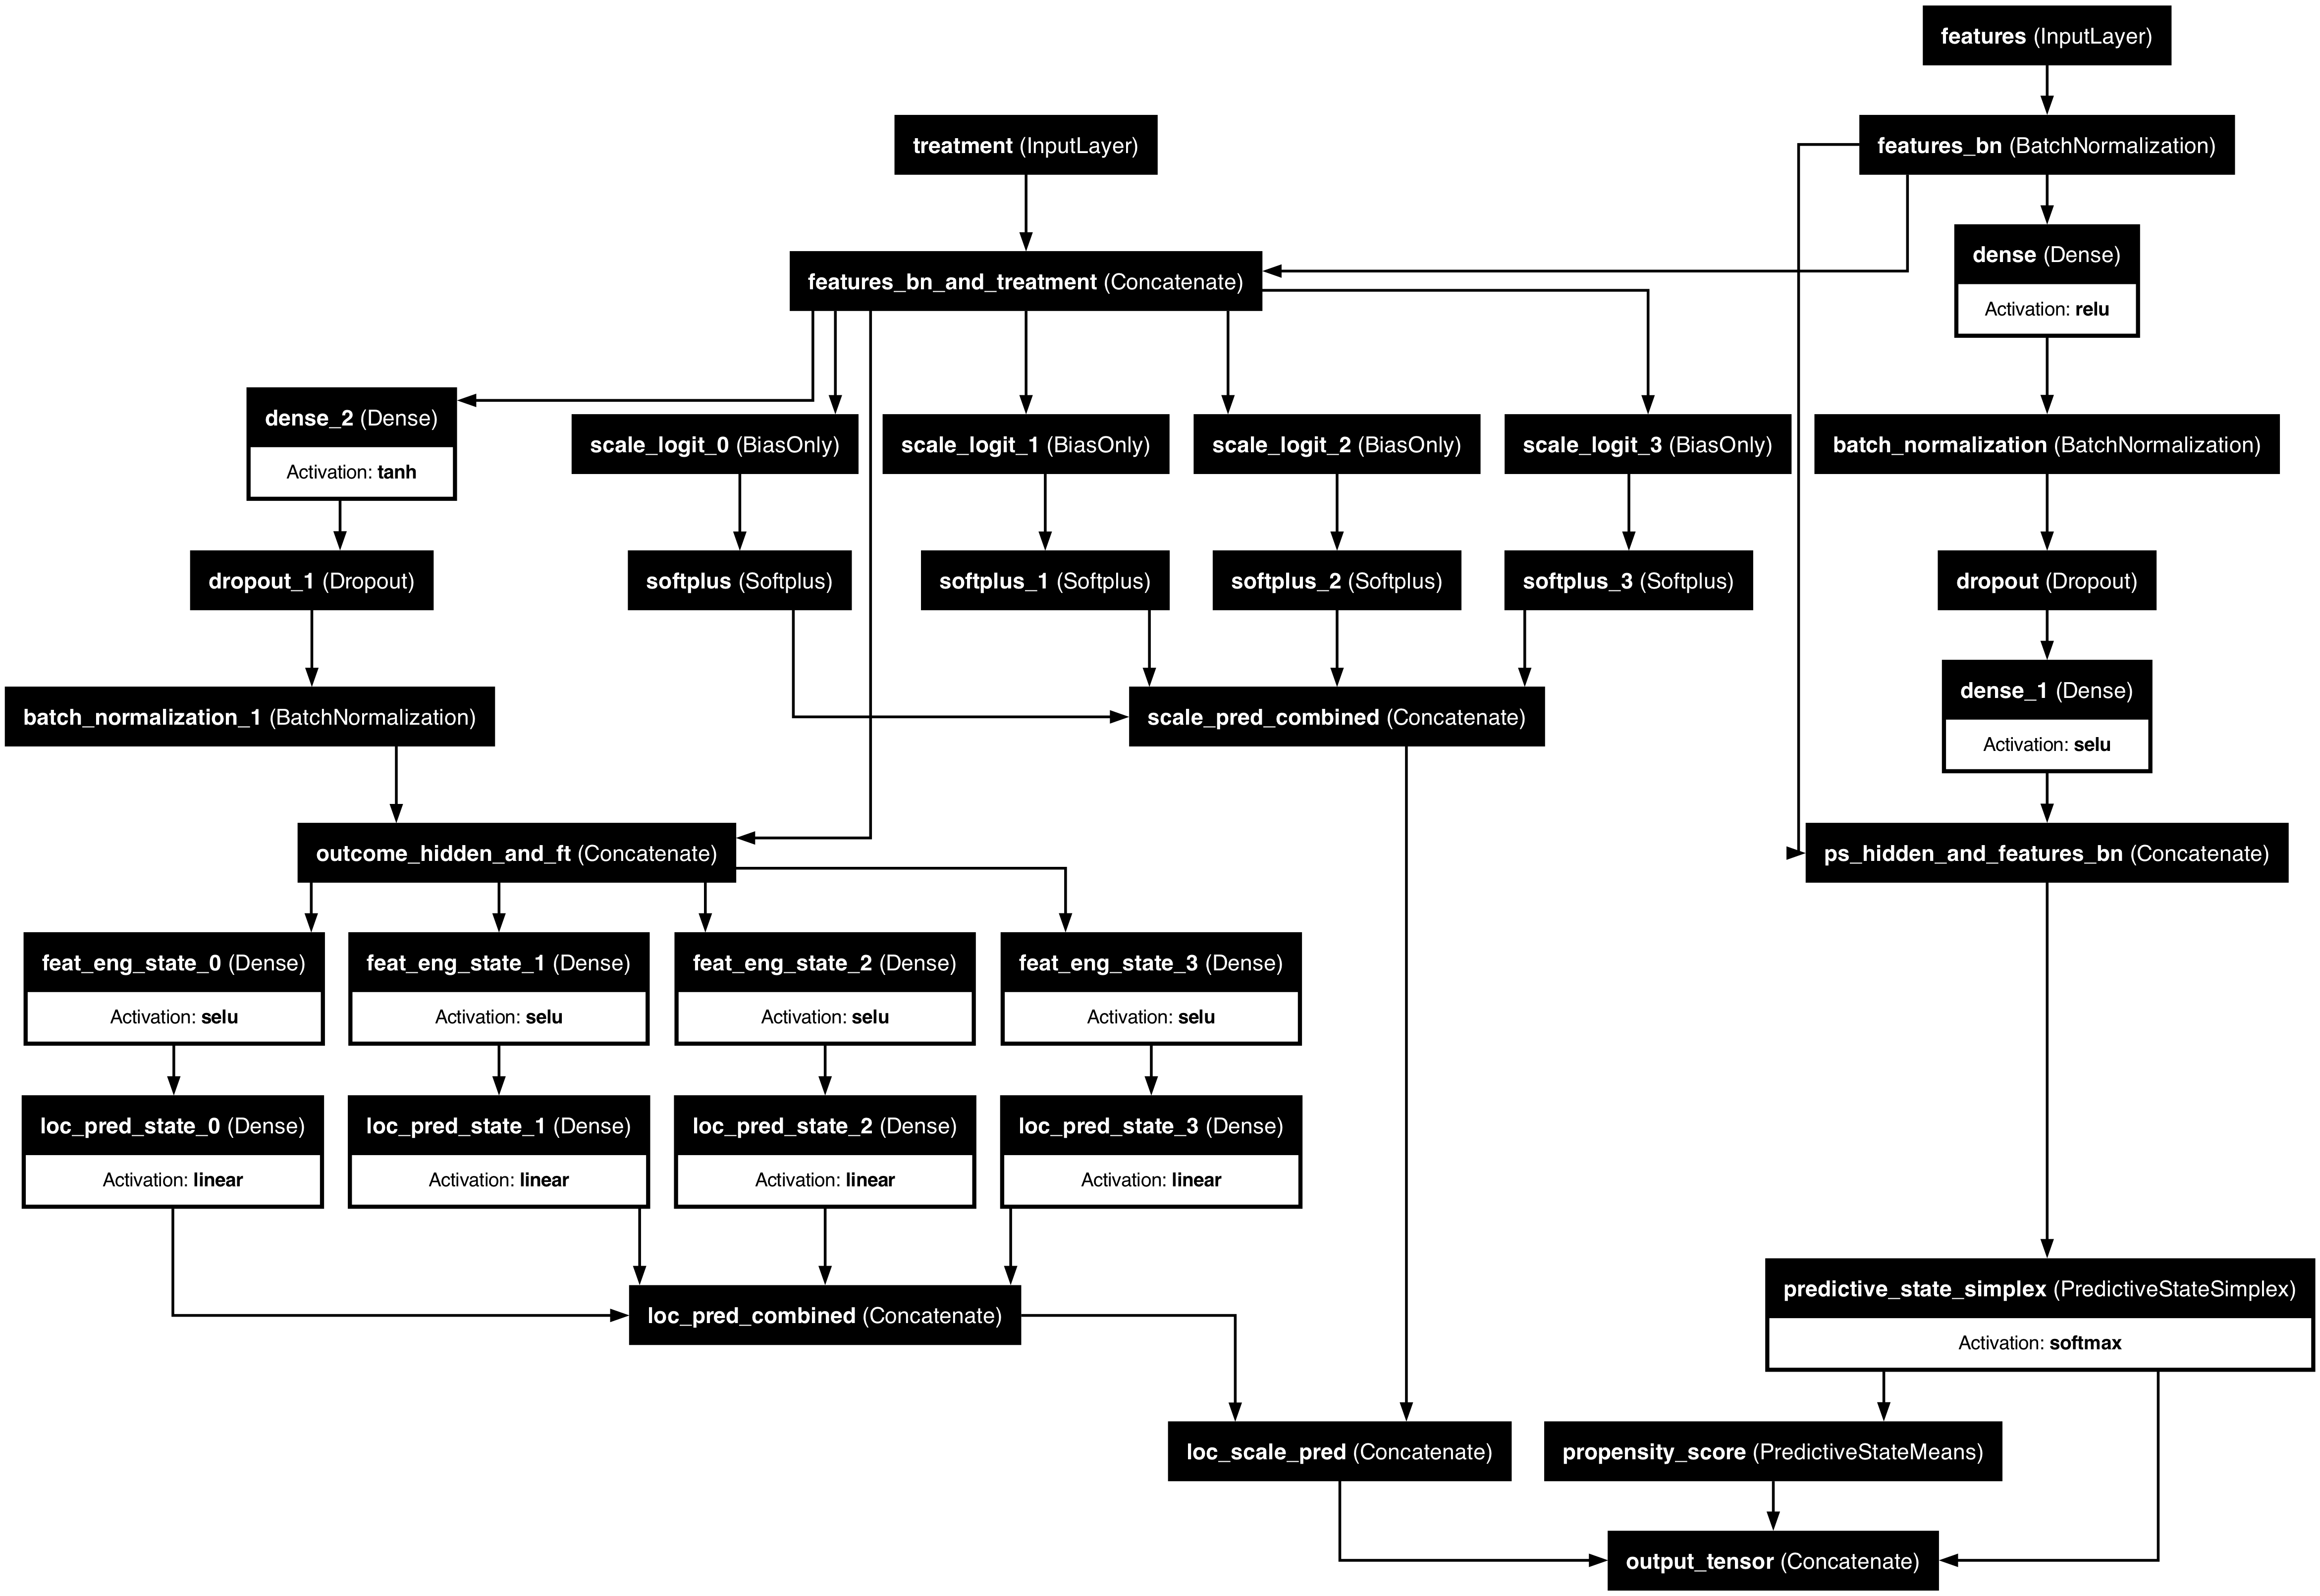

In [7]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_layer_activations=True)

In [8]:
model.layers[-2].state_conditional_means

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.65454715],
       [0.6220177 ],
       [0.7243923 ],
       [0.4778137 ]], dtype=float32)>

## Training model

In [9]:
inputs, outputs = ks_data.to_keras_inputs_outputs()
history = model.fit(inputs,
                    outputs,
                    epochs=250,
                    batch_size=64,
                    verbose=2,
                    validation_split=0.2,
                    callbacks=pypsps.keras.callbacks.recommended_callbacks(),
                   )

Epoch 1/250
13/13 - 4s - 341ms/step - binary_crossentropy: 0.7155 - loss: 44801.1562 - mean_squared_error: 49117.9062 - propensity_score_auc: 0.4569 - val_binary_crossentropy: 0.7027 - val_loss: 37395.1680 - val_mean_squared_error: 49786.0781 - val_propensity_score_auc: 0.5688 - learning_rate: 0.0200
Epoch 2/250
13/13 - 0s - 7ms/step - binary_crossentropy: 0.7060 - loss: 30591.1250 - mean_squared_error: 47621.0664 - propensity_score_auc: 0.5249 - val_binary_crossentropy: 0.6926 - val_loss: 24989.1934 - val_mean_squared_error: 48082.0859 - val_propensity_score_auc: 0.5572 - learning_rate: 0.0200
Epoch 3/250
13/13 - 0s - 7ms/step - binary_crossentropy: 0.6994 - loss: 19897.7832 - mean_squared_error: 44898.6406 - propensity_score_auc: 0.5131 - val_binary_crossentropy: 0.6843 - val_loss: 16278.7676 - val_mean_squared_error: 44280.0742 - val_propensity_score_auc: 0.6006 - learning_rate: 0.0200
Epoch 4/250
13/13 - 0s - 9ms/step - binary_crossentropy: 0.6978 - loss: 11535.6924 - mean_squared_

## Model convergence evaluation

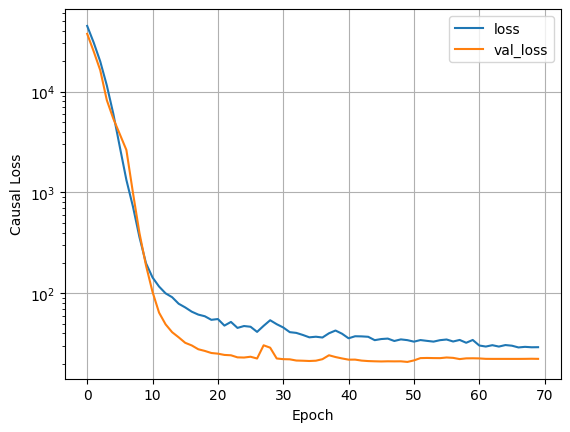

In [10]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Causal Loss")
plt.grid()

In [11]:
pd.DataFrame(history.history)

,binary_crossentropy,loss,mean_squared_error,propensity_score_auc,val_binary_crossentropy,val_loss,val_mean_squared_error,val_propensity_score_auc,learning_rate
0,0.715526,44801.156250,49117.906250,0.456864,0.702675,37395.167969,49786.078125,0.568753,0.020
1,0.706019,30591.125000,47621.066406,0.524857,0.692629,24989.193359,48082.085938,0.557187,0.020
2,0.699427,19897.783203,44898.640625,0.513066,0.684333,16278.767578,44280.074219,0.600642,0.020
3,0.697839,11535.692383,39282.601562,0.503746,0.682590,8238.036133,36914.988281,0.638640,0.020
4,0.694421,6019.214844,33142.726562,0.491822,0.693508,5385.041016,32739.169922,0.507835,0.020
...,...,...,...,...,...,...,...,...,...
65,0.689819,30.172283,24603.751953,0.548574,0.689025,22.320618,25259.648438,0.554449,0.002
66,0.690078,28.995152,24602.824219,0.541903,0.689017,22.322248,25259.623047,0.554449,0.002
67,0.689675,29.391899,24603.560547,0.547291,0.688947,22.346264,25259.595703,0.560064,0.002
68,0.689982,29.108637,24603.277344,0.545561,0.688793,22.397150,25259.572266,0.560064,0.002


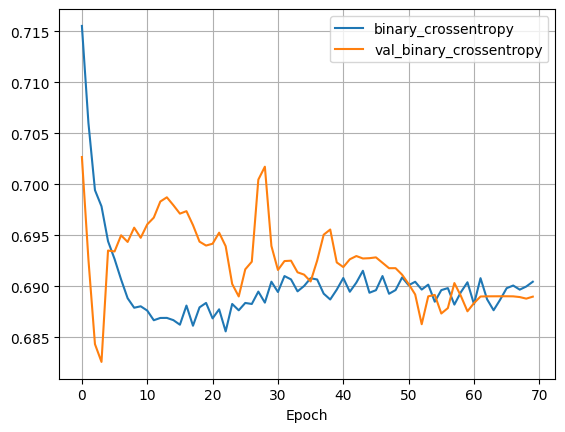

In [12]:
pd.DataFrame(history.history)[["binary_crossentropy", "val_binary_crossentropy"]].plot()
plt.xlabel("Epoch")
plt.grid()

In [13]:
model.layers[-2].state_conditional_means

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.6623825 ],
       [0.5813503 ],
       [0.5118797 ],
       [0.44969586]], dtype=float32)>

## Causal predictions & inference

In [14]:
preds = model.predict(inputs, verbose=0)
outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(preds,
                                                                     model.loss._outcome_loss._n_outcome_pred_cols,
                                                                     model.loss._outcome_loss._n_treatment_pred_cols)

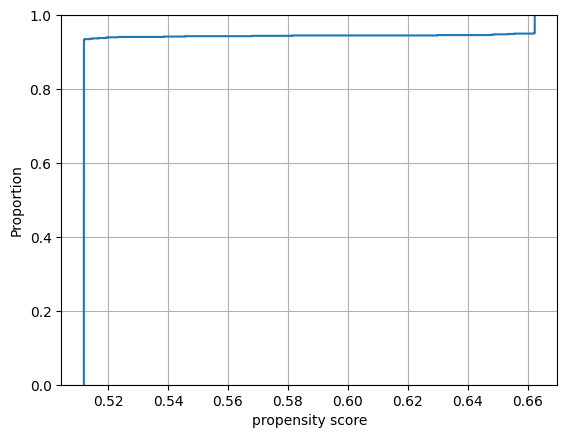

In [15]:
sns.ecdfplot(pd.Series(propensity_score.ravel()))
plt.xlabel("propensity score")
plt.grid()

<Axes: >

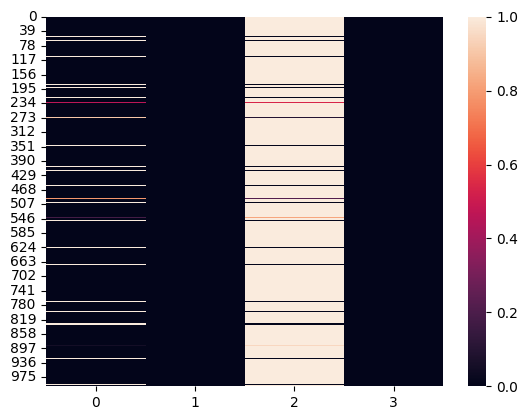

In [16]:
sns.heatmap(weights)

In [17]:
pred_ate = pypsps.inference.predict_ate_binary(model, inputs[0])
print("True ATE: %f; predicted ATE: %f" % (ks_data.true_ate, pred_ate))

True ATE: 20.000000; predicted ATE: 18.813229


## Appendix (debug)

In [ ]:
nnl = pypsps.keras.neglogliks.NegloglikNormal(reduction="none")
nnl(outputs[:10, 0:1], outcome_preds[:10, [0, 4]])

In [ ]:
import importlib
importlib.reload(pypsps.keras.losses)

psps_outcome_loss = pypsps.keras.losses.OutcomeLoss(
    loss=pypsps.keras.neglogliks.NegloglikNormal(reduction="none"), reduction="sum_over_batch_size",
    n_outcome_true_cols=1,
    n_outcome_pred_cols=2,
    n_treatment_pred_cols=1,
)
psps_treat_loss = pypsps.keras.losses.TreatmentLoss(loss=tf.keras.losses.BinaryCrossentropy(reduction="none"), 
                                                    reduction="sum_over_batch_size",
                                                       n_outcome_true_cols=1,
    n_outcome_pred_cols=2,
    n_treatment_pred_cols=1,)

psps_outcome_loss(outputs, preds), psps_treat_loss(outputs, preds)

In [ ]:
psps_outcome_loss(outputs, preds).shape

In [ ]:
model.loss._outcome_loss(y_true=outputs, y_pred=preds)